In [1]:
import numpy as np
import pandas as pd
import neurodsp

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# A. Raw data

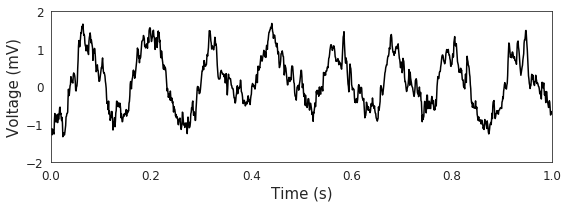

In [2]:
# Load data
lfp = np.load('data/ca1.npy')
lfp = lfp[:20000]
Fs = 1250
f_theta = (4, 10)

# Plot raw data
raw_data_sample_lims = (11000, 12250)
raw_lfp = lfp[raw_data_sample_lims[0]:raw_data_sample_lims[1]]
t = np.arange(0, len(raw_lfp)/Fs, 1/Fs)
plt.figure(figsize=(8,3))
plt.plot(t, raw_lfp/1000, 'k')
plt.xlim((0,1))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (mV)', size=15)
plt.xticks(size=12)
plt.yticks(np.linspace(-2,2,5), size=12)
plt.tight_layout()
plt.savefig('figs/1A_rawlfp.png')

# B. Lowpass filter

In [3]:
# Apply 25Hz lowpass filters
lfp = neurodsp.filter(lfp, Fs, 'lowpass', 25, N_seconds=.5, remove_edge_artifacts=False)

Transition bandwidth is 2.4 Hz. Pass/stop bandwidth is 25 Hz


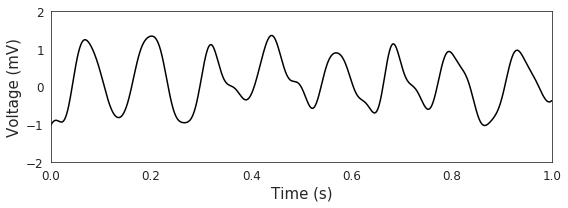

In [4]:
# Limit LFP to timeframe of interest
lfp_plt = lfp[raw_data_sample_lims[0]:raw_data_sample_lims[1]]
t = np.arange(0, len(lfp_plt)/Fs, 1/Fs)

plt.figure(figsize=(8,3))
plt.plot(t, lfp_plt/1000, 'k')
plt.xlim((0,1))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (mV)', size=15)
plt.xticks(size=12)
plt.yticks(np.linspace(-2,2,5), size=12)
plt.tight_layout()
plt.savefig('figs/1B_broad_bandpass.png')

# C. Determine zero-crossings in narrow bandpass

In [5]:
# Narrow bandpass of LFP
from bycycle.cyclepoints import _fzerofall, _fzerorise

lfp_narrow = neurodsp.filter(lfp, Fs, 'bandpass', f_theta, N_seconds=.75,
                             remove_edge_artifacts=False)

# Determine zerocrossings
zeroriseN = _fzerorise(lfp_narrow)
zerofallN = _fzerofall(lfp_narrow)

Transition bandwidth is 2.4 Hz. Pass/stop bandwidth is 6 Hz


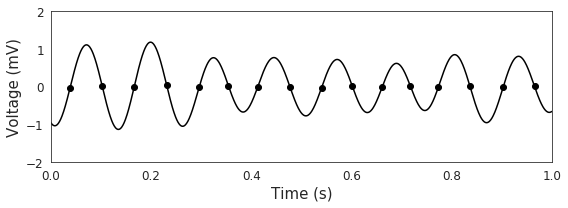

In [6]:
# Limit LFP to timeframe of interest
lfp_plt = lfp_narrow[raw_data_sample_lims[0]:raw_data_sample_lims[1]]
t = np.arange(0, len(lfp_plt)/Fs, 1/Fs)

# Limit zerocrossings to time of interest
zeroriseN = zeroriseN[(zeroriseN >= raw_data_sample_lims[0]) &(zeroriseN < raw_data_sample_lims[1])] - raw_data_sample_lims[0]
zerofallN = zerofallN[(zerofallN >= raw_data_sample_lims[0]) &(zerofallN < raw_data_sample_lims[1])] - raw_data_sample_lims[0]

# Visualize zerocrossings on bandpass data
plt.figure(figsize=(8,3))
plt.plot(t, lfp_plt/1000, 'k')
plt.plot(t[zeroriseN], lfp_plt[zeroriseN]/1000, 'ko')
plt.plot(t[zerofallN], lfp_plt[zerofallN]/1000, 'ko')
plt.xlim((0,1))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (mV)', size=15)
plt.xticks(size=12)
plt.yticks(np.linspace(-2,2,5), size=12)
plt.tight_layout()
plt.savefig('figs/1C_zerocrossings.png')

# D. Determine timepoints of oscillatory extrema

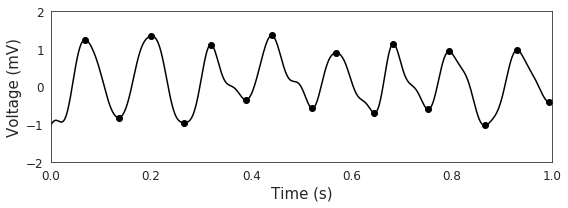

In [7]:
# Find peaks and troughs
from bycycle.cyclepoints import find_extrema
Ps, Ts = find_extrema(lfp, Fs, f_theta, filter_kwargs={'N_seconds': .75})

# Limit LFP to timeframe of interest
lfp_plt = lfp[raw_data_sample_lims[0]:raw_data_sample_lims[1]]
t = np.arange(0, len(lfp_plt)/Fs, 1/Fs)

# Limit extrema to time of interest
Ps_plt = Ps[(Ps >= raw_data_sample_lims[0]) & (Ps < raw_data_sample_lims[1])] - raw_data_sample_lims[0]
Ts_plt = Ts[(Ts >= raw_data_sample_lims[0]) & (Ts < raw_data_sample_lims[1])] - raw_data_sample_lims[0]

plt.figure(figsize=(8,3))
plt.plot(t, lfp_plt/1000, 'k')
plt.plot(t[Ps_plt], lfp_plt[Ps_plt]/1000, 'ko')
plt.plot(t[Ts_plt], lfp_plt[Ts_plt]/1000, 'ko')
plt.xlim((0,1))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (mV)', size=15)
plt.xticks(size=12)
plt.yticks(np.linspace(-2,2,5), size=12)
plt.tight_layout()
plt.savefig('figs/1D_peaks_and_troughs.png')

# E. Determine flank midpoints in each cycle

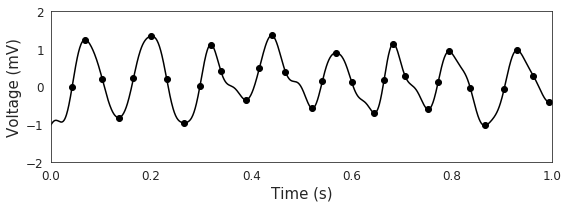

In [8]:
# Find zerocrossings
from bycycle.cyclepoints import find_zerox
zeroxR, zeroxD = find_zerox(lfp, Ps, Ts)

# Limit zerocrossings to time of interest
zeroxR_plt = zeroxR[(zeroxR >= raw_data_sample_lims[0]) & (zeroxR < raw_data_sample_lims[1])] - raw_data_sample_lims[0]
zeroxD_plt = zeroxD[(zeroxD >= raw_data_sample_lims[0]) & (zeroxD < raw_data_sample_lims[1])] - raw_data_sample_lims[0]

# Plot zerocrossings together with extrema
plt.figure(figsize=(8,3))
plt.plot(t, lfp_plt/1000, 'k')
plt.plot(t[Ps_plt], lfp_plt[Ps_plt]/1000, 'ko')
plt.plot(t[Ts_plt], lfp_plt[Ts_plt]/1000, 'ko')
plt.plot(t[zeroxR_plt], lfp_plt[zeroxR_plt]/1000, 'ko')
plt.plot(t[zeroxD_plt], lfp_plt[zeroxD_plt]/1000, 'ko')
plt.xlim((0,1))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (mV)', size=15)
plt.xticks(size=12)
plt.yticks(np.linspace(-2,2,5), size=12)
plt.tight_layout()
plt.savefig('figs/1E_flank_midpoints.png')

# F. Compute phase time series
Think I'll remove this

In [9]:
# # Compute phase time series
# pha = neurodsp.shape.extrema_interpolated_phase(lfp, Ps, Ts, zeroxR=zeroxR, zeroxD=zeroxD)

# # Compute Hilbert phase
# pha_hilbert = neurodsp.phase_by_time(lfp, Fs, f_theta)

# # Limit phase time series to time of interest
# pha_plt = pha[raw_data_sample_lims[0]:raw_data_sample_lims[1]]
# pha_plt_hilbert = pha_hilbert[raw_data_sample_lims[0]:raw_data_sample_lims[1]]

# # Plot zerocrossings together with extrema
# plt.figure(figsize=(11,3))
# plt.plot(t, pha_plt, 'k', alpha=.8, label='Extrema')
# plt.plot(t, pha_plt_hilbert, 'r', alpha=.8, label='Hilbert')
# plt.xlim((0,1))
# plt.xlabel('Time (s)', size=15)
# plt.ylabel('Phase (rad)', size=15)
# plt.xticks(size=12)
# plt.yticks([-np.pi,0,np.pi],['$-\pi$',0,'$\pi$'], size=12)
# plt.gca().legend(title='Phase\nEstimation\nMethod', fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.setp(plt.gca().get_legend().get_title(), fontsize='12')
# plt.tight_layout(rect=[0,0,0.75,1])
# plt.savefig('figs/1F_phase.png')

# G. Plot lines for computing symmetries

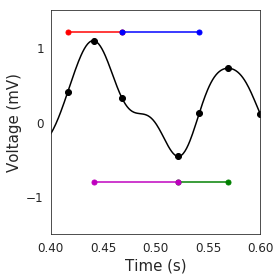

In [10]:
x_lims = (.4, .6)
tr_idx = 3

# Plot a cycle
plt.figure(figsize=(4,4))
plt.plot(t, lfp_plt/Fs, 'k')
plt.plot(t[Ps_plt], lfp_plt[Ps_plt]/Fs, 'ko')
plt.plot(t[Ts_plt], lfp_plt[Ts_plt]/Fs, 'ko')
plt.plot(t[zeroxR_plt], lfp_plt[zeroxR_plt]/Fs, 'ko')
plt.plot(t[zeroxD_plt], lfp_plt[zeroxD_plt]/Fs, 'ko')
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (mV)', size=15)
plt.xticks(size=12)
plt.yticks(np.linspace(-2,2,5), size=12)
plt.tight_layout()
plt.xlim(x_lims)
plt.ylim((-1.5, 1.5))

# Plot lines for each part of the cycle
plt.plot([t[zeroxR_plt][tr_idx], t[zeroxD_plt][tr_idx]], [1.2, 1.2], 'r.-', ms=10)
plt.plot([t[zeroxD_plt][tr_idx], t[zeroxR_plt][tr_idx+1]], [1.2, 1.2], 'b.-', ms=10)
plt.plot([t[Ts_plt][tr_idx], t[Ps_plt][tr_idx+1]], [-.8, -.8], 'g.-', ms=10)
plt.plot([t[Ps_plt][tr_idx], t[Ts_plt][tr_idx]], [-.8, -.8], 'm.-', ms=10)

plt.tight_layout()
plt.savefig('figs/1G_symmetries.png')

In [11]:
# Print rise, decay, peak, and trough times
print('peak', int(Fs*(t[zeroxD_plt][tr_idx] - t[zeroxR_plt][tr_idx])), 'ms')
print('trough', int(Fs*(t[zeroxR_plt][tr_idx+1] - t[zeroxD_plt][tr_idx])), 'ms')
print('rise', int(Fs*(t[Ps_plt][tr_idx+1] - t[Ts_plt][tr_idx])), 'ms')
print('decay', int(Fs*(t[Ts_plt][tr_idx] - t[Ps_plt][tr_idx])), 'ms')

# Print rdsym and ptsym
print('rdsym', (t[Ps_plt][tr_idx+1] - t[Ts_plt][tr_idx]) / (t[Ps_plt][tr_idx+1] - t[Ps_plt][tr_idx]))
print('ptsym', (t[zeroxD_plt][tr_idx] - t[zeroxR_plt][tr_idx]) / (t[zeroxR_plt][tr_idx+1] - t[zeroxR_plt][tr_idx]))

peak 64 ms
trough 92 ms
rise 58 ms
decay 101 ms
rdsym 0.3687499999999994
ptsym 0.414012738853503
